# Run Paul 3 soil layers
Compare run FLUXNET with Paul soil data (instead of the ones used from satellites) with only 3 soil layers instead of 20

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import calendar
import os

In [4]:
site = 'oas'
site_longname = 'BERMS Old Aspen, Saskatchewan, Canada'
y_start = 1998
y_end = 2009

# labels = ['run_FLUXNET']
labels = ['run_FLUXNET', 'run_Paul_3_soil_layers']

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'+site+'/'
paths = [root_path+label for label in labels]

ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [5]:
# Paul's SnowMIP data

path_paul = '/home/lalandmi/Dropbox/data/SnowMIP/Paul/CLASS_Results'
label_paul = "SnowMIP"

df_paul = pd.read_csv(path_paul+'/CLASS_sv_REF_'+site+'_'+str(y_start-1)+'_'+str(y_end+1)+'.txt', delim_whitespace=True)
df_paul.index = pd.to_datetime(df_paul[['year', 'month', 'day', 'hour']]).values
df_paul= df_paul.drop(columns=['year', 'month', 'day', 'hour'])
df_paul.albsn = df_paul.albsn.replace({0 : np.nan})
df_paul.albs = df_paul.albs.replace({0 : np.nan})
df_paul.tsn = df_paul.tsn.replace({-999 : np.nan})
df_paul.tsns = df_paul.tsns.replace({-999 : np.nan})
ds_paul_h = df_paul.to_xarray()
ds_paul_h = ds_paul_h.rename({'index': 'time'})
ds_paul_h.load()

ds_paul_d = ds_paul_h.resample(time='D').mean().load()

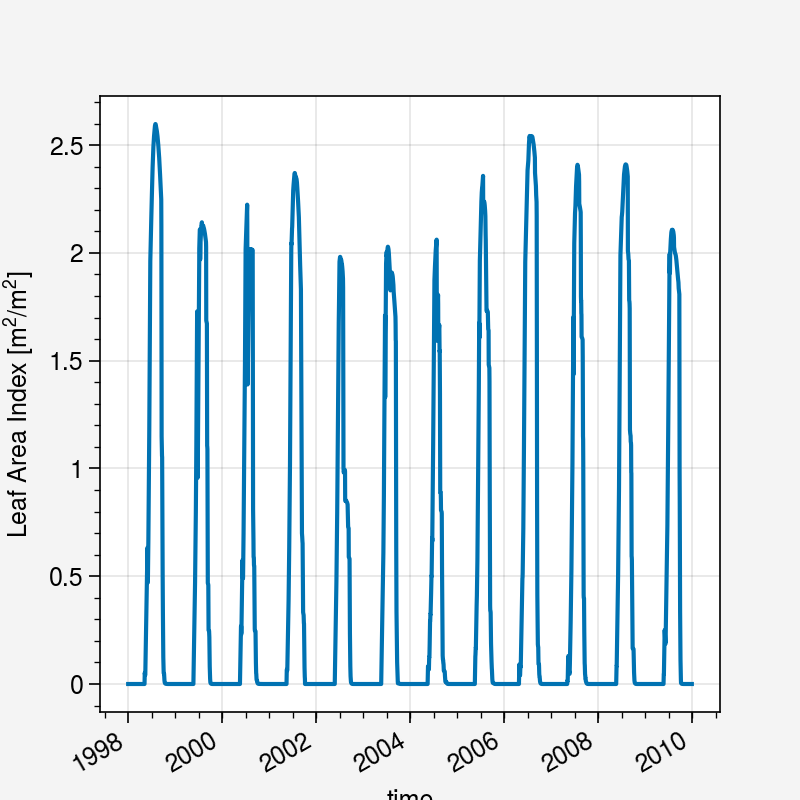

In [6]:
ds_d_list[1].lai.plot()

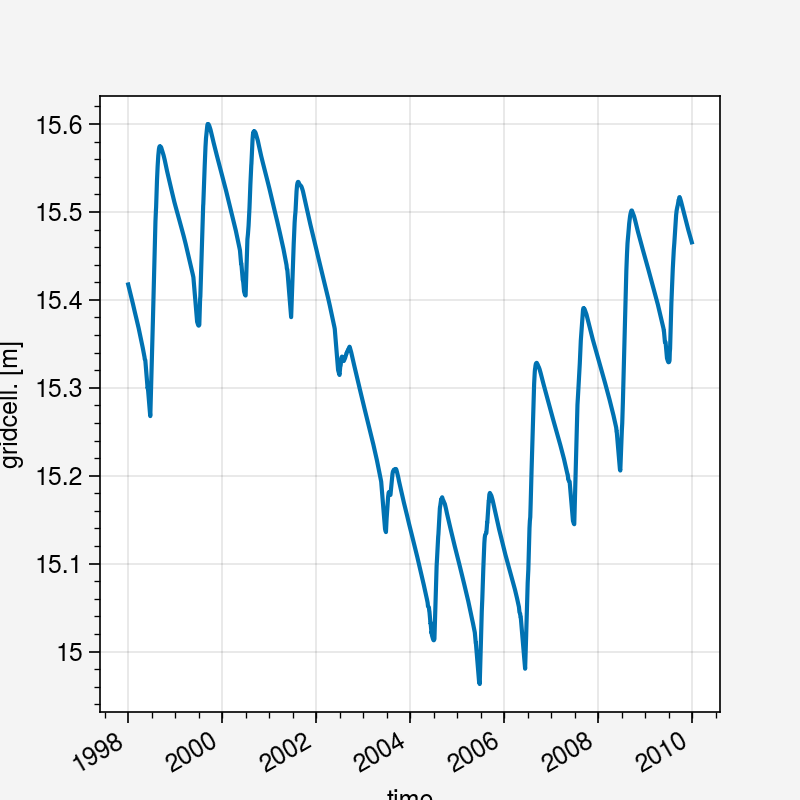

In [7]:
ds_d_list[1].vegHeight.plot()

Text(0.5, 0.98, 'BERMS Old Aspen, Saskatchewan, Canada (1998-2009)')

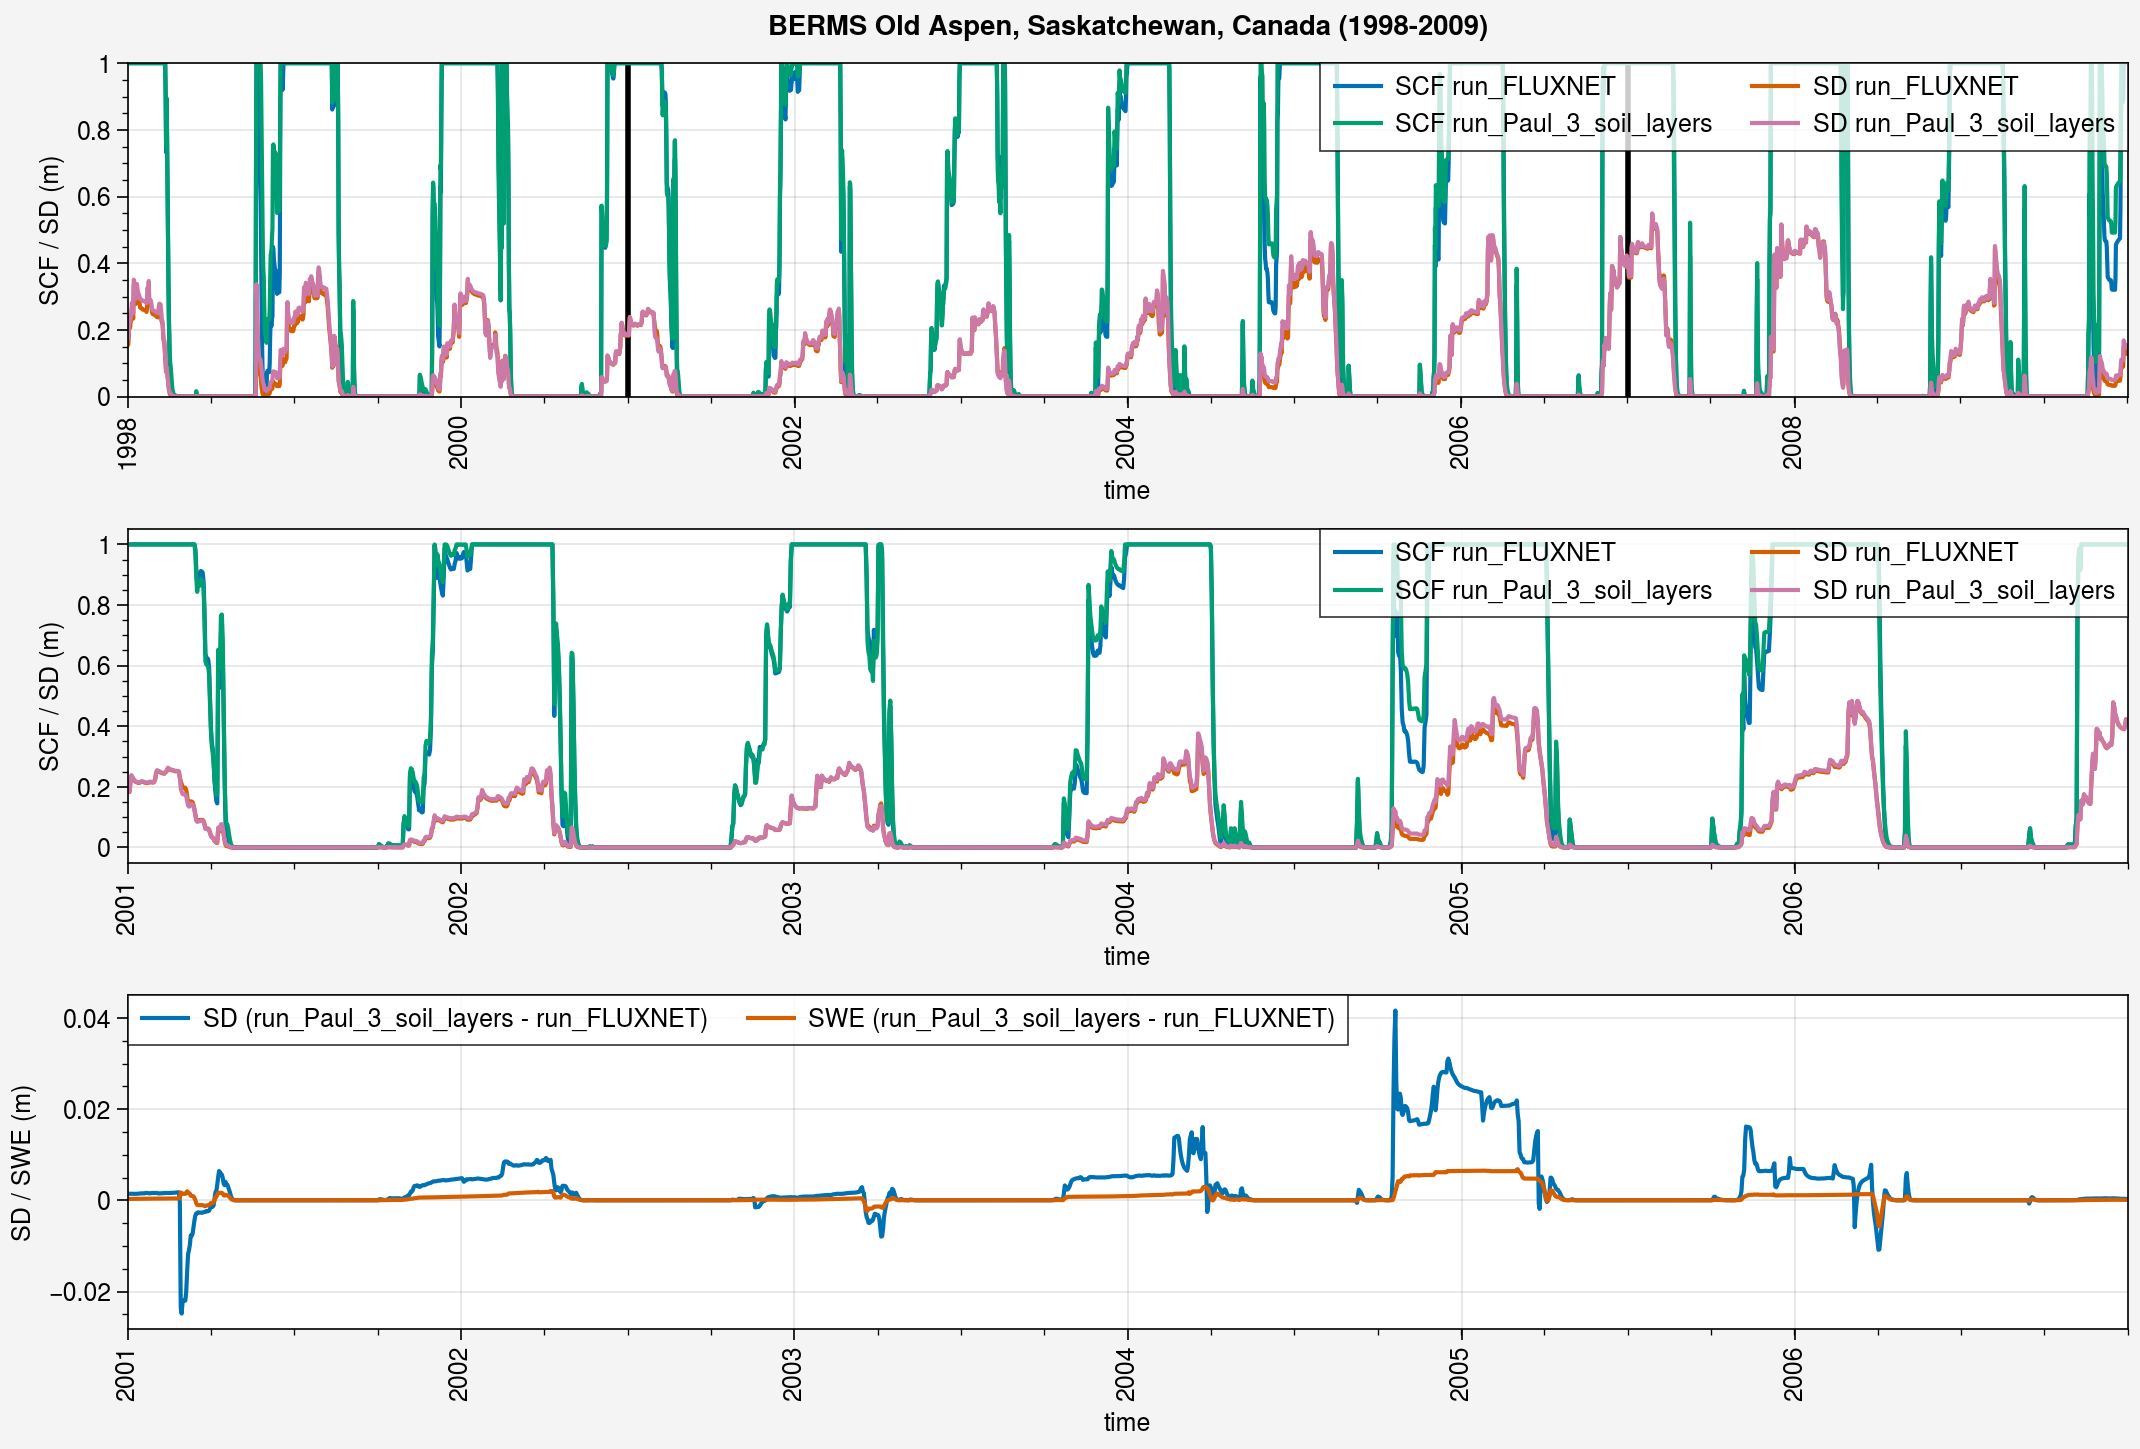

In [8]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+3)
end = str(y_end-3)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


## Compare with obs

In [9]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_h_eval_menard2019 = xr.open_dataset(path_menard2019+'/obs_insitu_'+site+'_'+str(y_start-1)+'_'+str(y_end+1)+'.nc').load()
ds_d_eval_menard2019 = ds_h_eval_menard2019.resample(time='D').mean().load()
ds_h_eval_menard2019

<xarray.Dataset>
Dimensions:       (time: 113952, sdepth: 3)
Coordinates:
  * time          (time) datetime64[ns] 1997-10-01T01:00:00 ... 2010-10-01
  * sdepth        (sdepth) float32 0.1 0.2 0.5
Data variables:
    albs          (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    rlus          (time) float32 365.1 367.7 369.5 366.9 ... 348.4 342.2 339.6
    snd_can_auto  (time) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    snd_gap_auto  (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    snd_man       (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    snw_man       (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    ts            (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    tsl           (time, sdepth) float32 9.75 9.781 9.686 ... 8.564 8.688 8.402

In [10]:
tot_year = y_end - y_start + 1
gap = 4
years = pplt.arange(y_start, y_end)
years

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009])

### SD

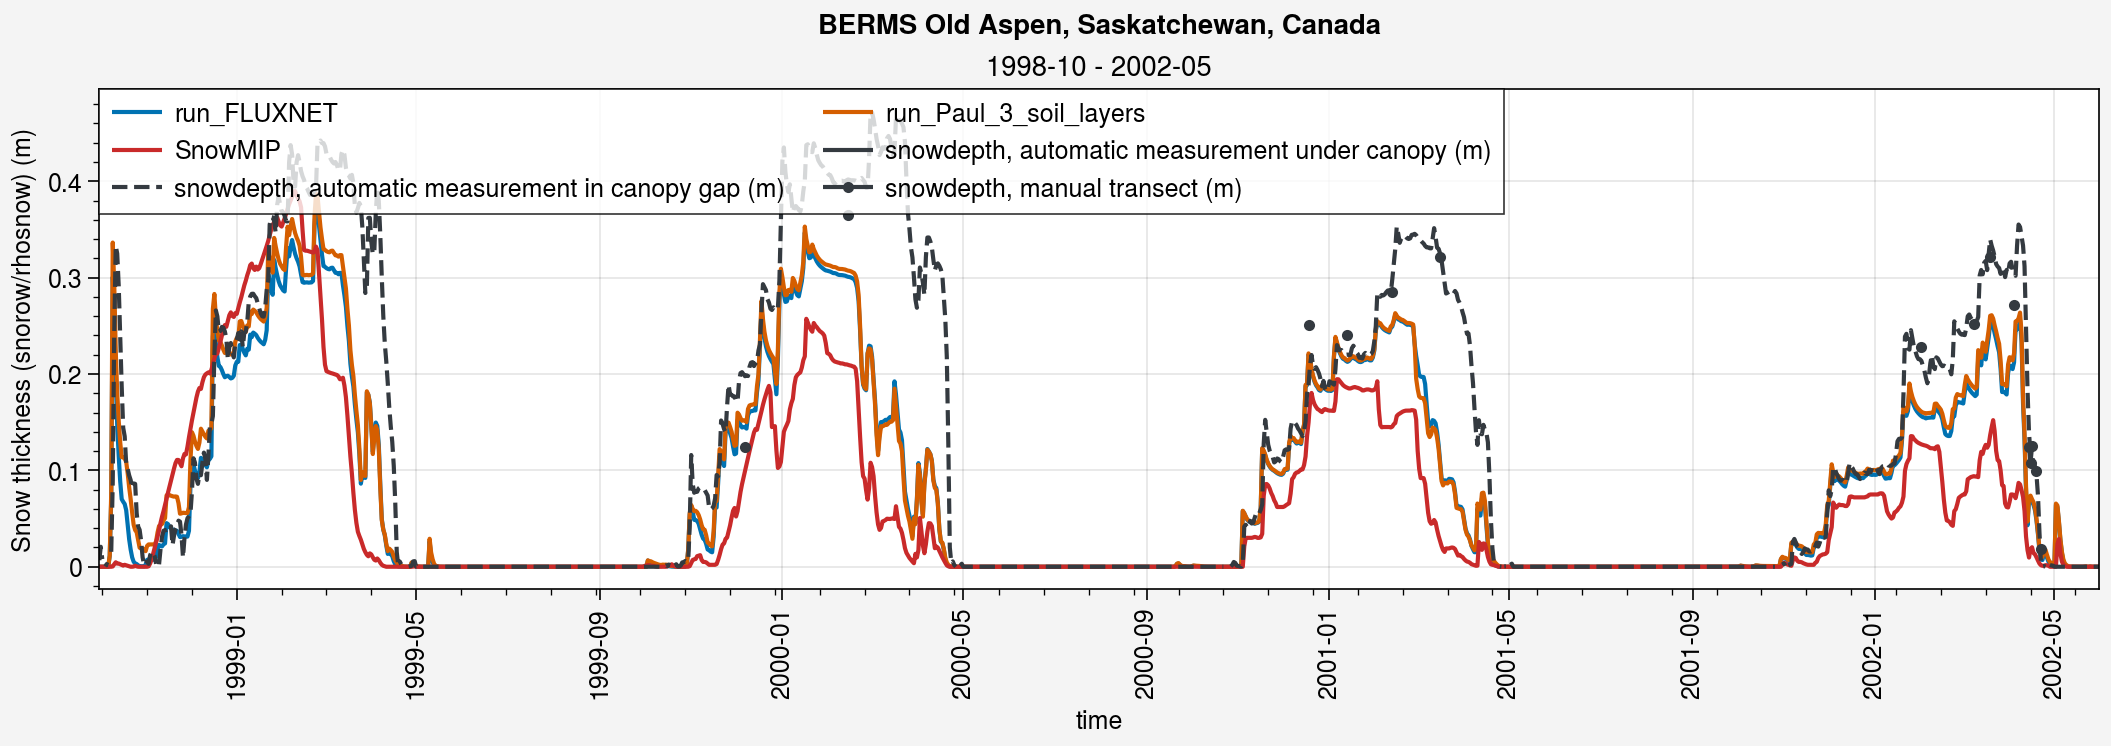

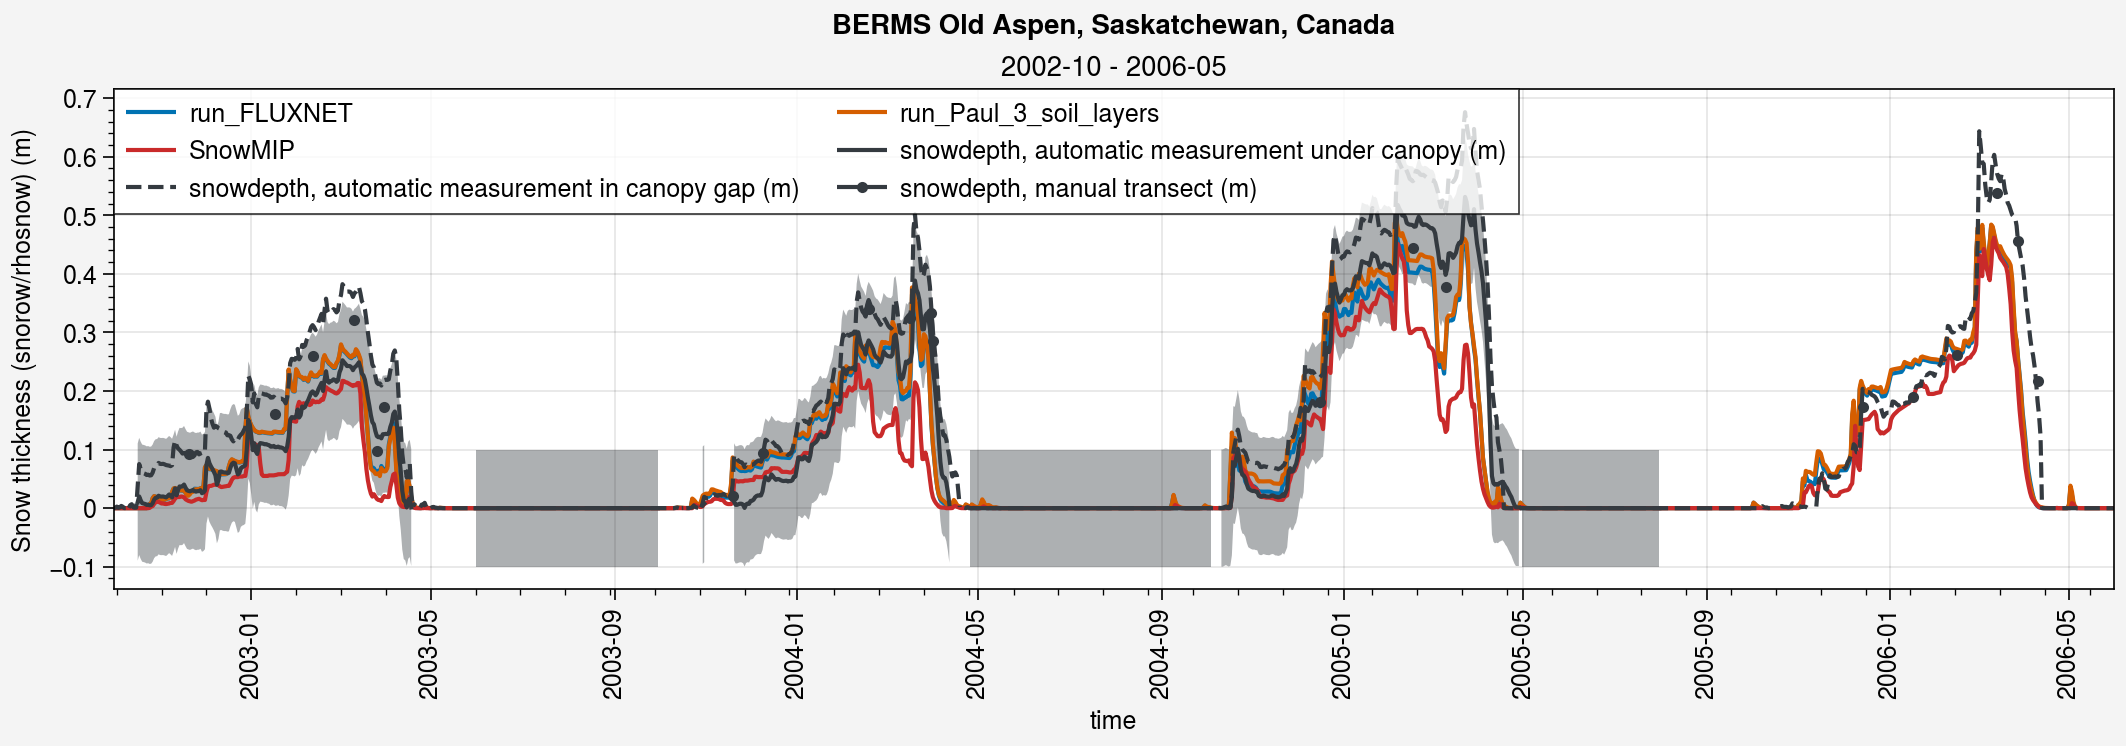

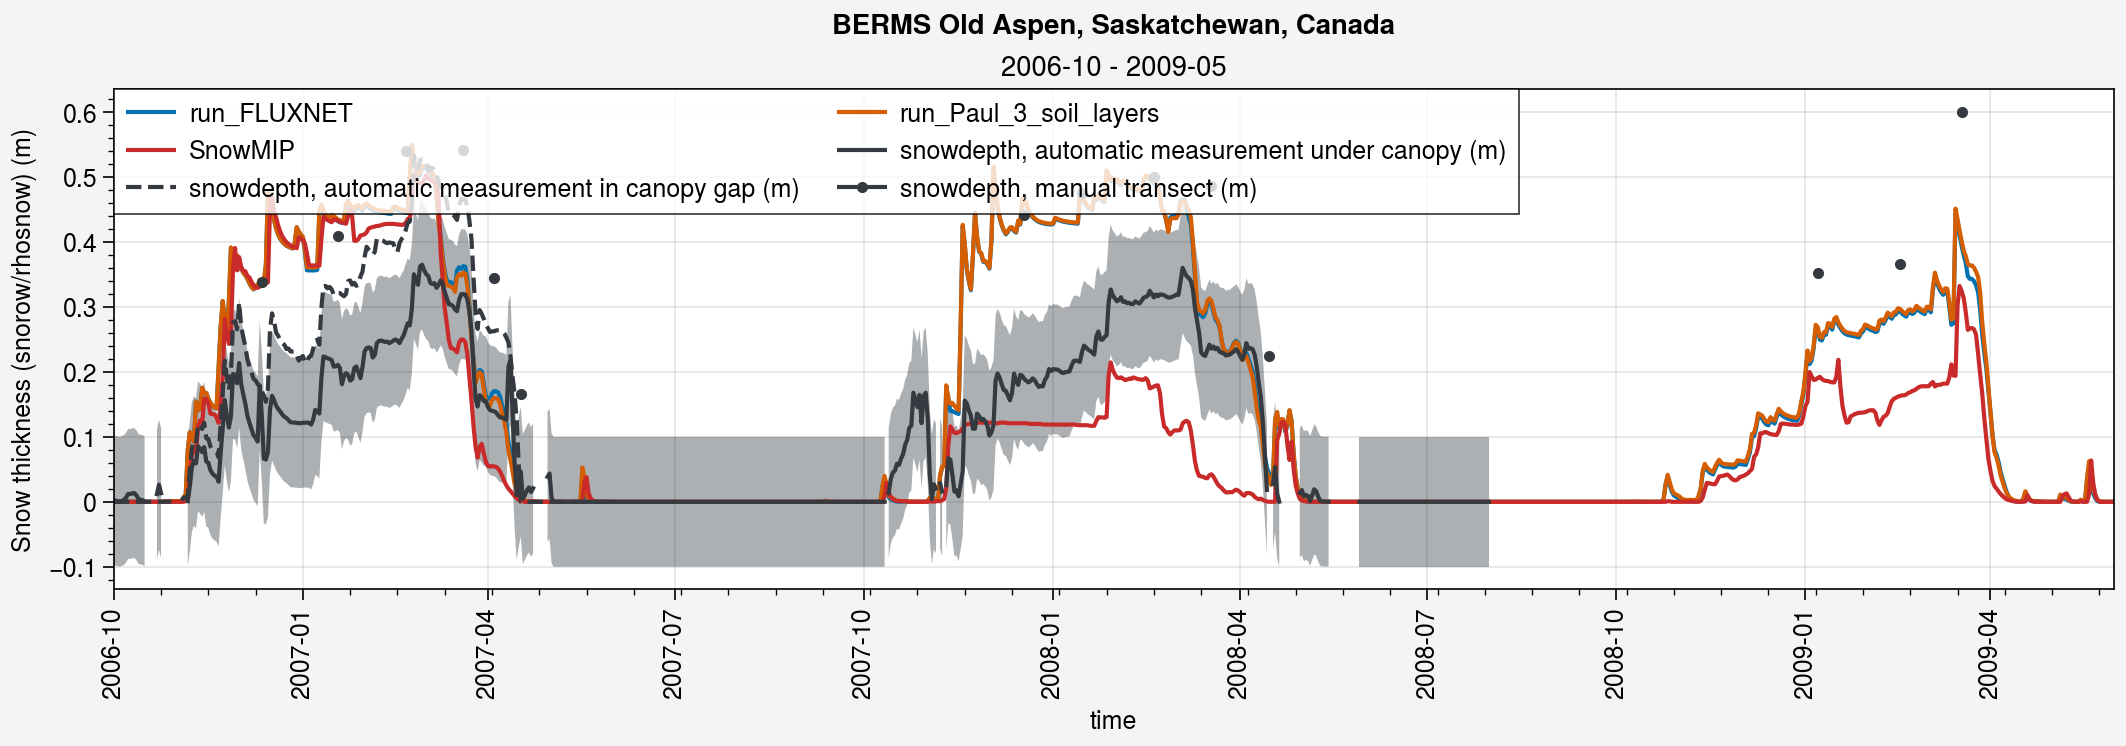

In [11]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.snd.sel(time=period), label=label_paul, color='red9')
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_eval_menard2019.snd_can_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_eval_menard2019.snd_can_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_eval_menard2019.snd_can_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    axs[0].plot(ds_d_eval_menard2019.snd_gap_auto.sel(time=period), color=color_obs, ls='--')
    axs[0].plot(ds_d_eval_menard2019.snd_man.sel(time=period), marker='.', color=color_obs)

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='k', alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)


### SWE

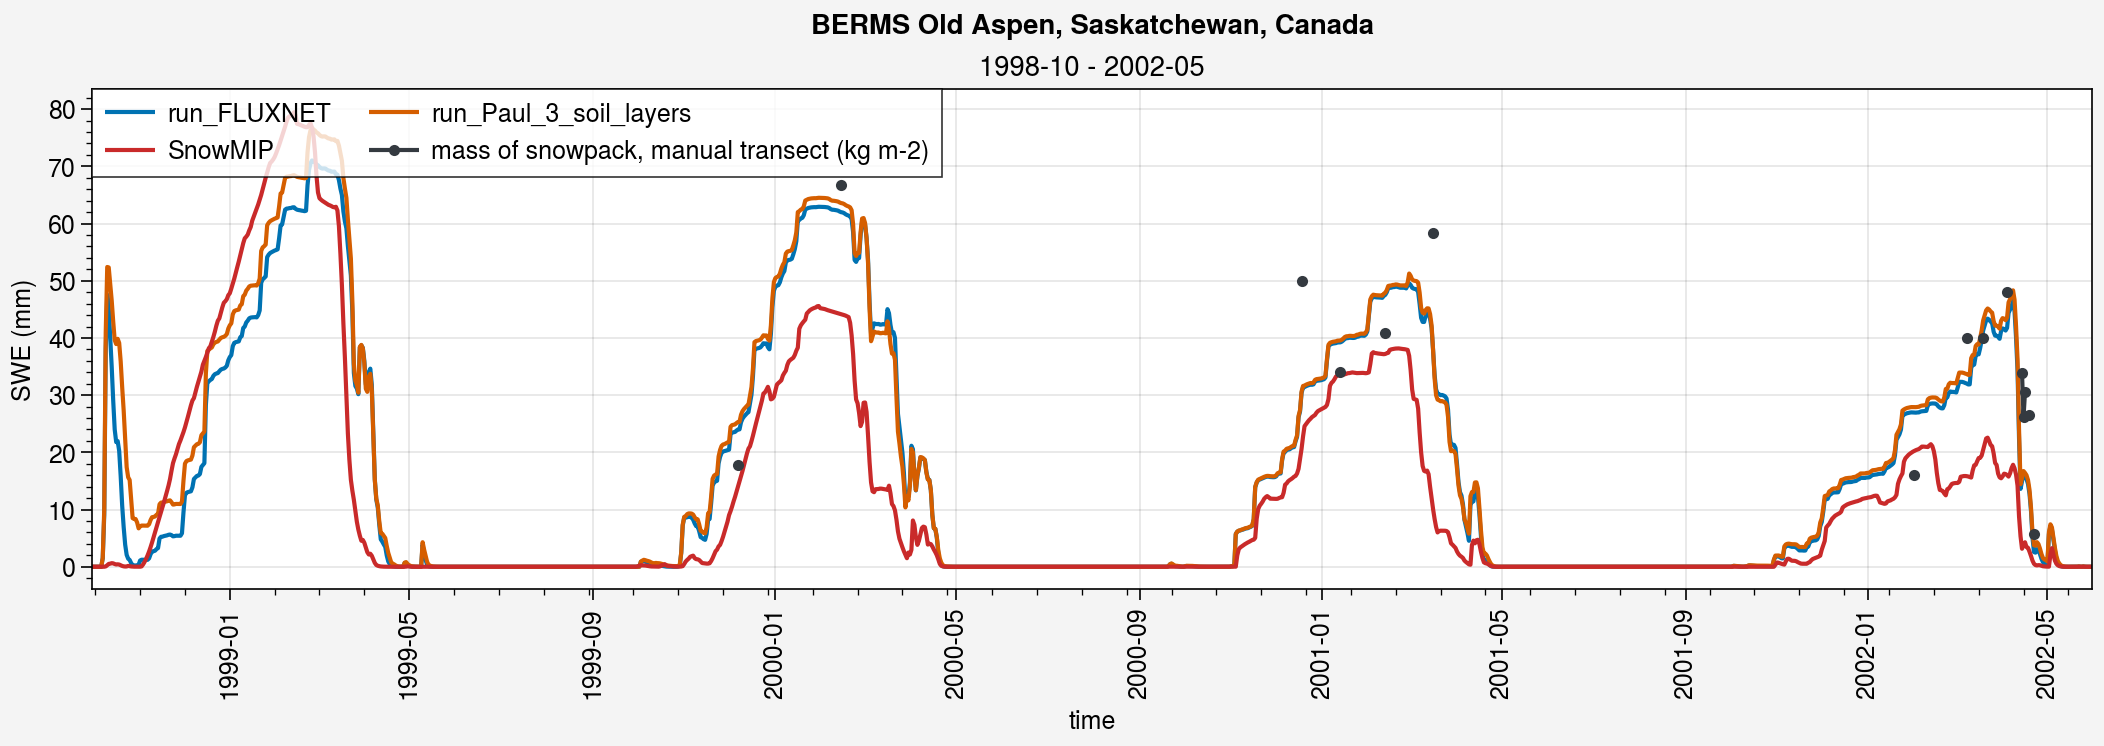

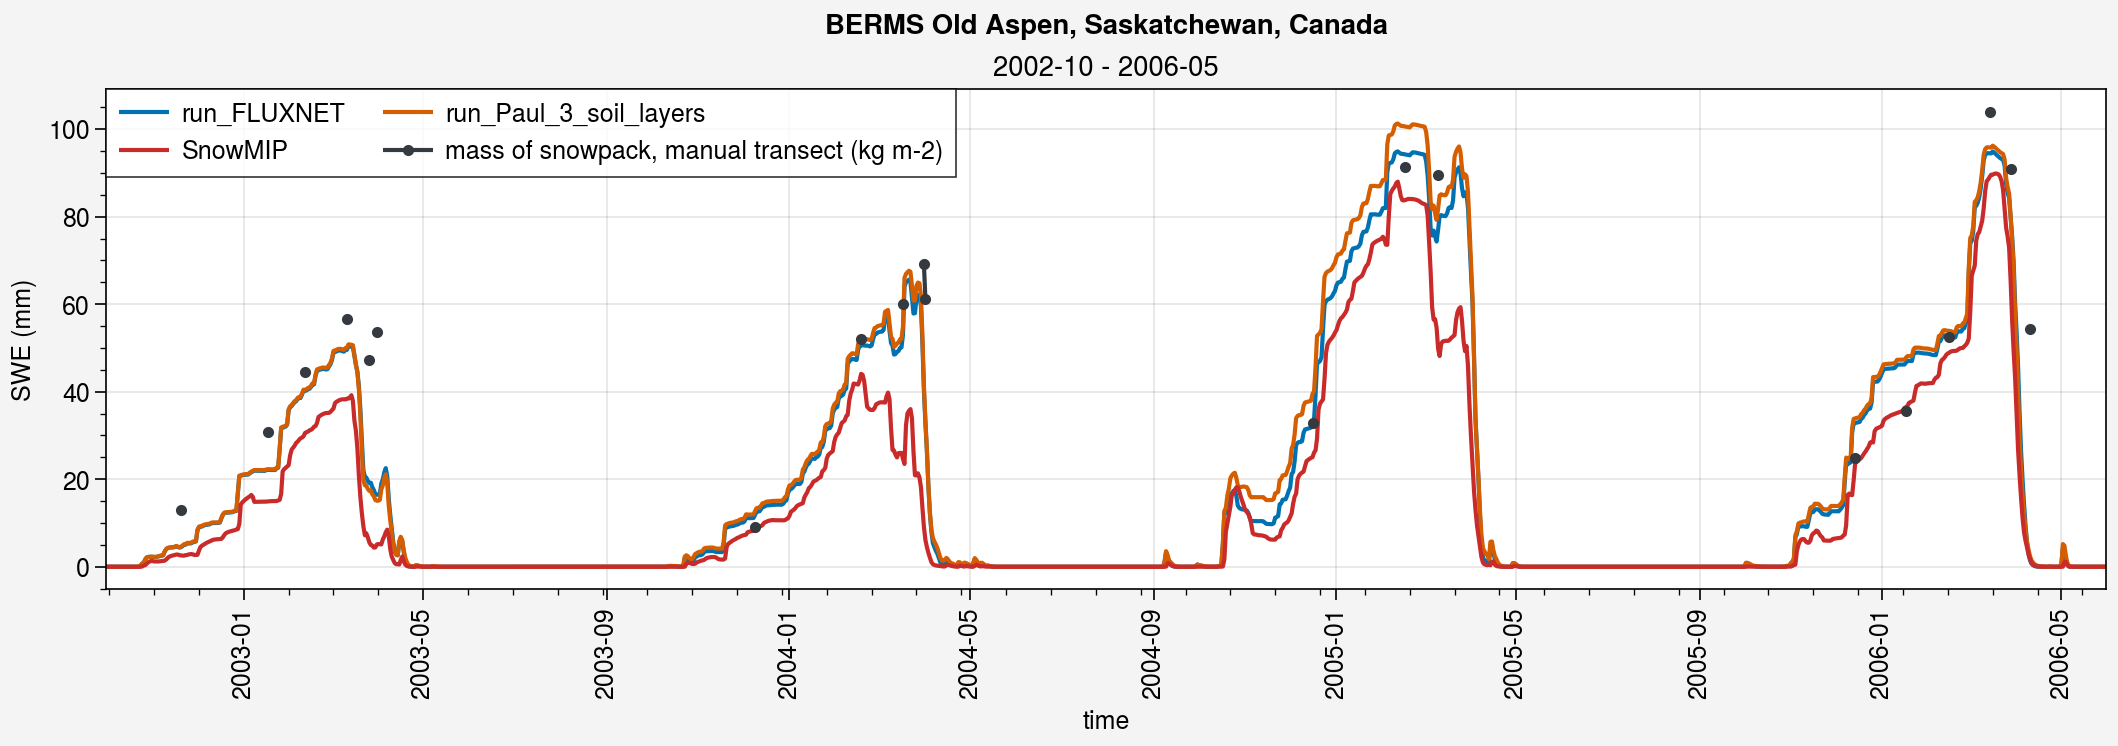

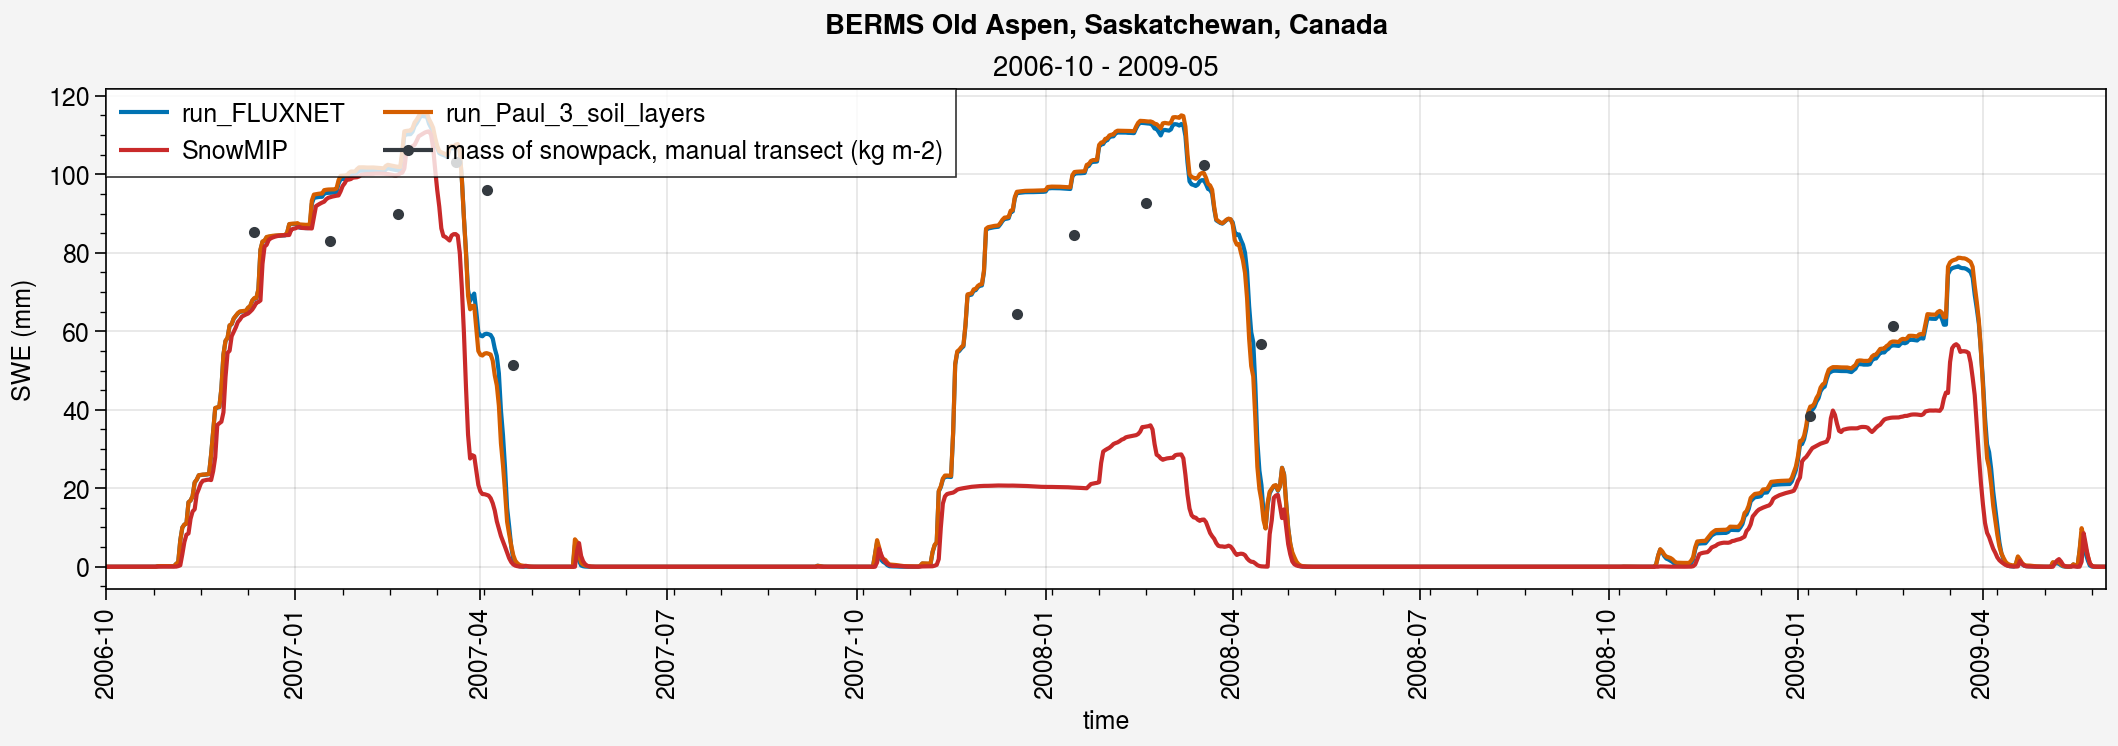

In [12]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.snw.sel(time=period), label=label_paul, color='red9')
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_eval_menard2019.snw_can_auto.sel(time=period).values+0.1, axis=0),
    #     np.expand_dims(ds_d_eval_menard2019.snw_can_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    # axs[0].plot(ds_d_eval_menard2019.snw_can_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_eval_menard2019.snw_gap_auto.sel(time=period), color=color_obs, ls='--')
    axs[0].plot(ds_d_eval_menard2019.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


### Albedo

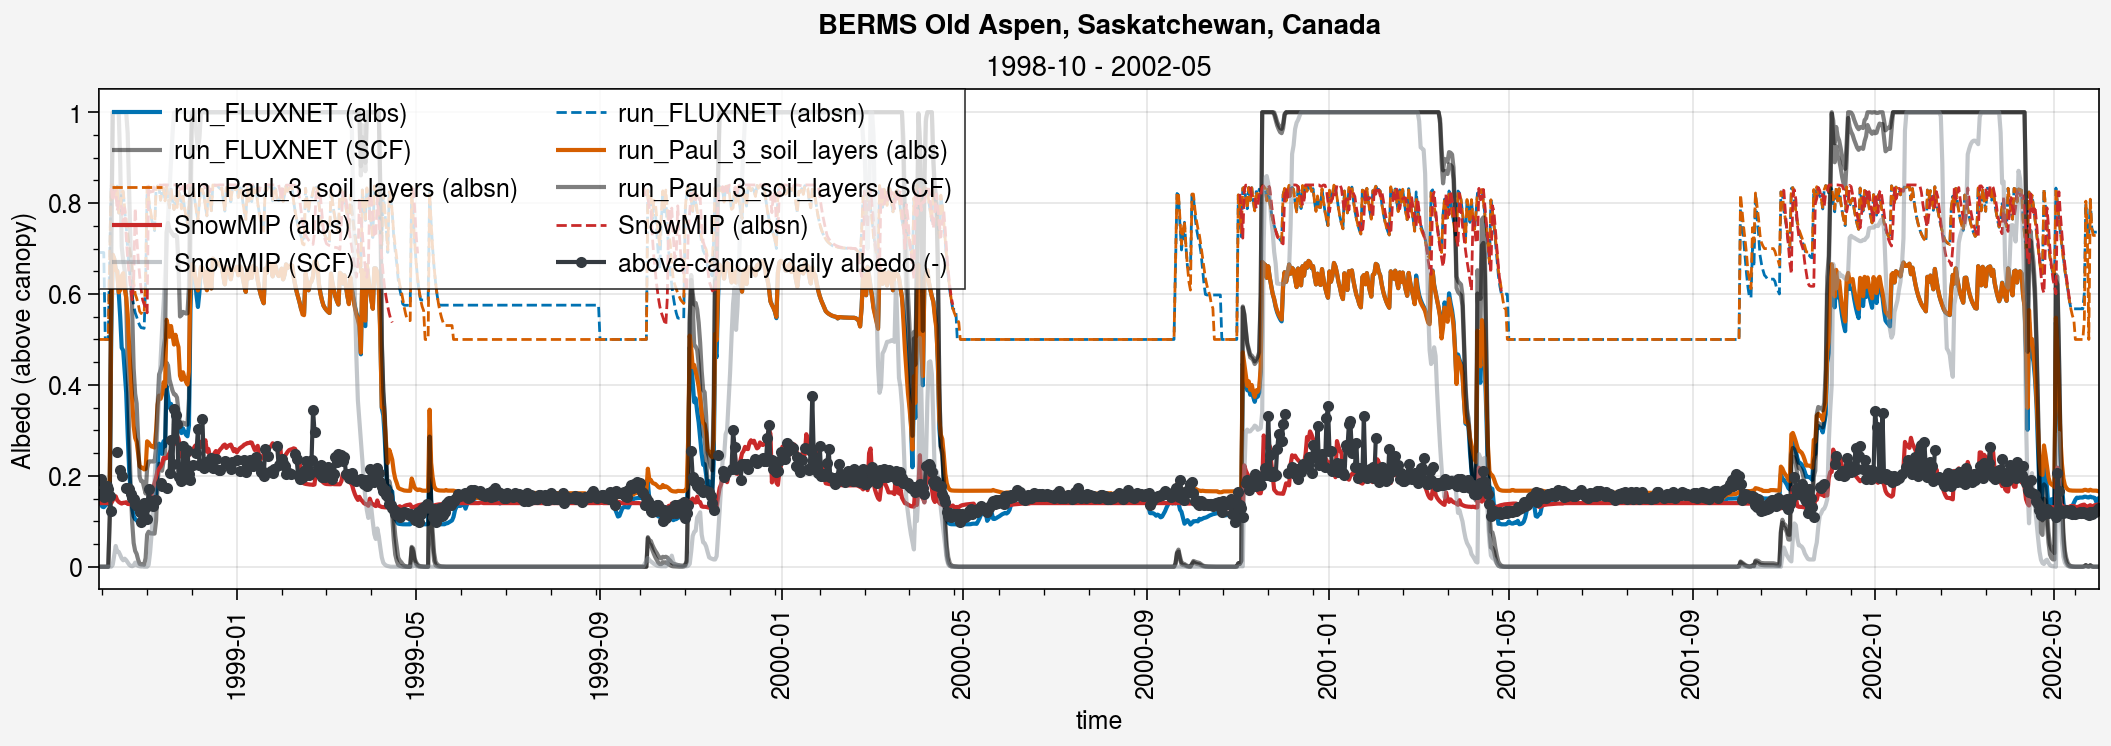

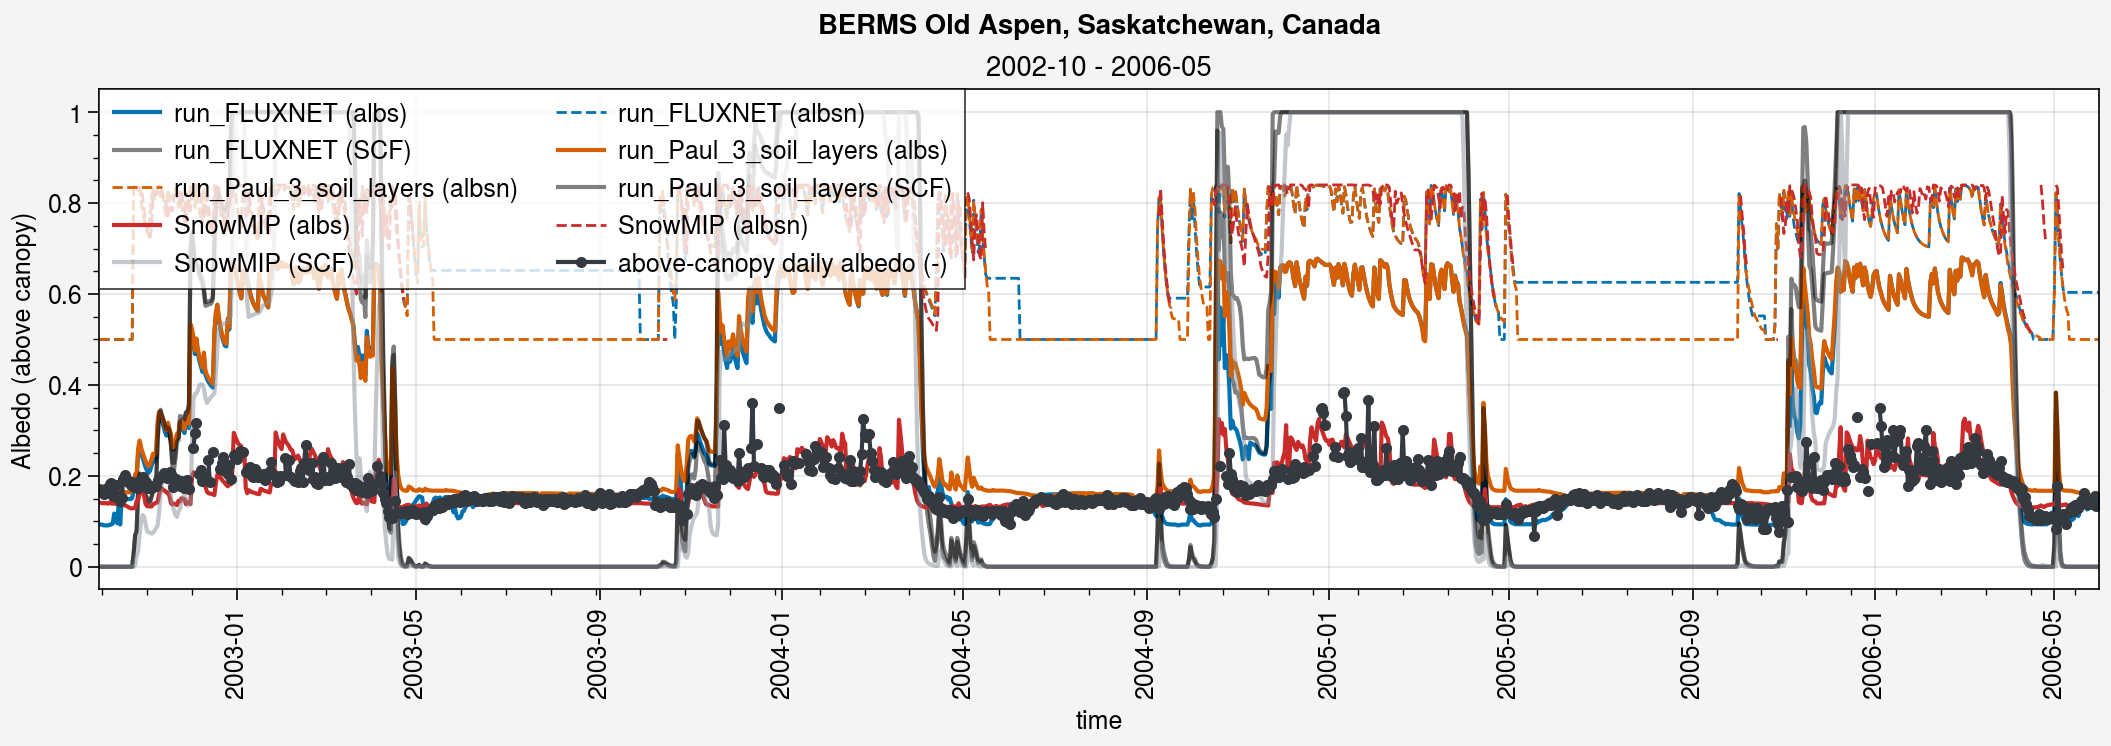

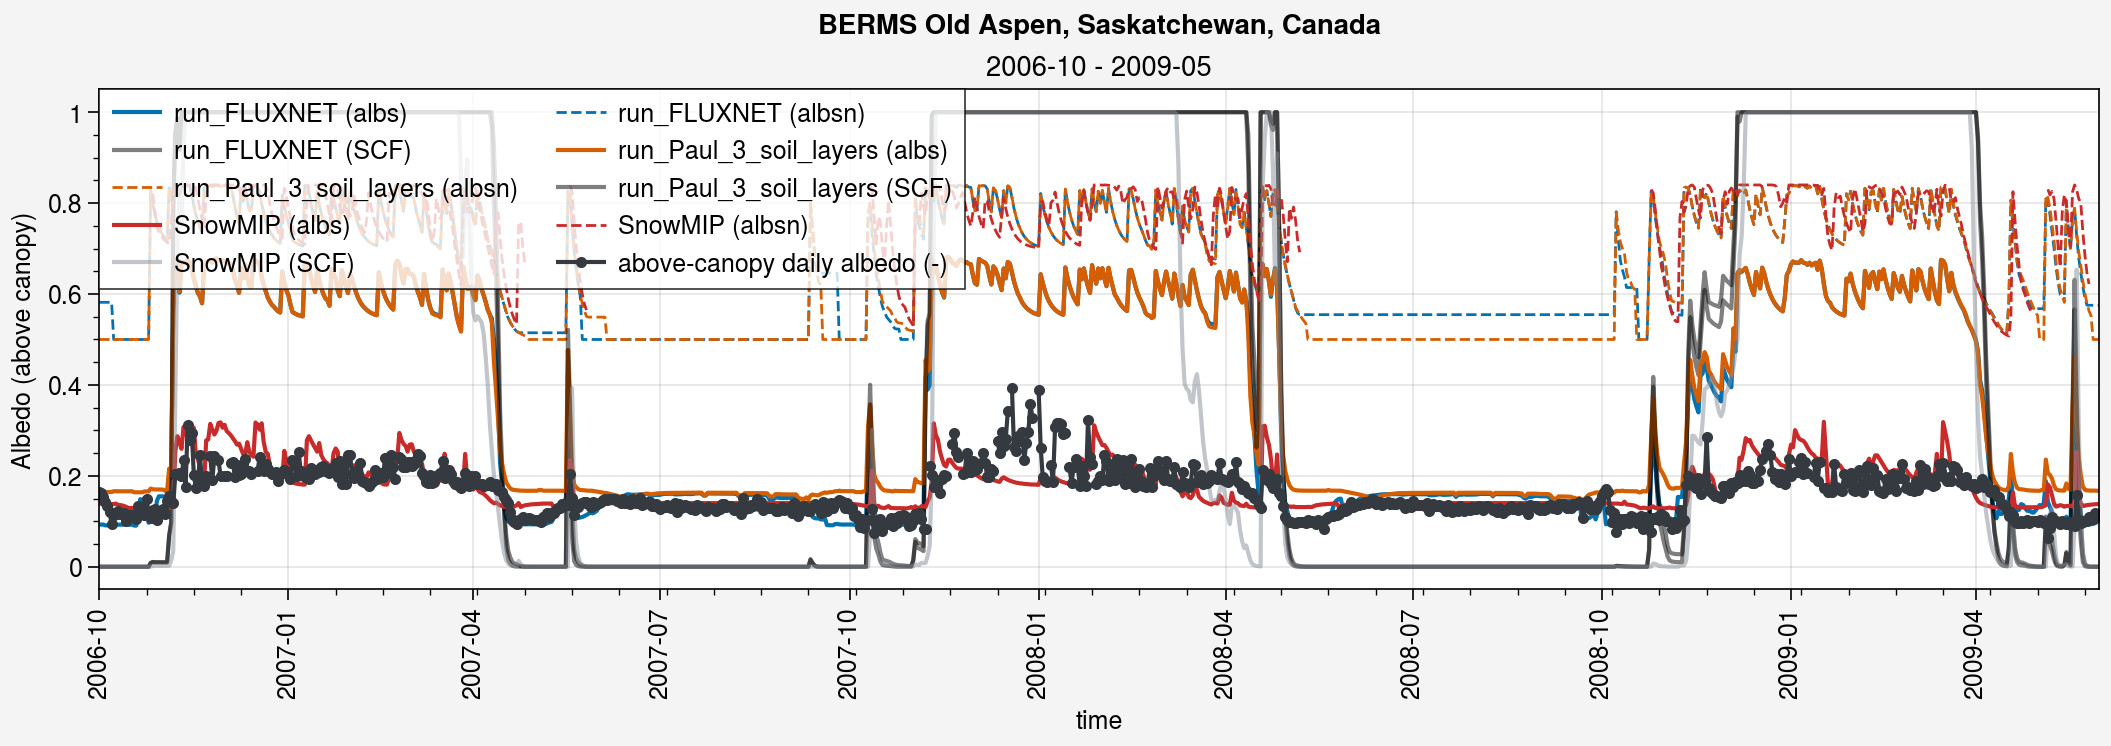

In [13]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    k = 0
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
        axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
        axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
        k+=1

    # SnowMIP
    axs[0].plot(ds_paul_d.albs.sel(time=period), label=label_paul+' (albs)', color='red9')
    axs[0].plot(ds_paul_d.albsn.sel(time=period), label=label_paul+' (albsn)', color='red9', ls='--', lw=1)
    axs[0].plot(ds_paul_d.snc.sel(time=period), label=label_paul+' (SCF)', color='gray6', alpha=0.5)
    
    # Obs
    axs[0].plot(ds_d_eval_menard2019.albs.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo (above canopy)')
    
    fig.suptitle(site_longname)


### Surface Temperature

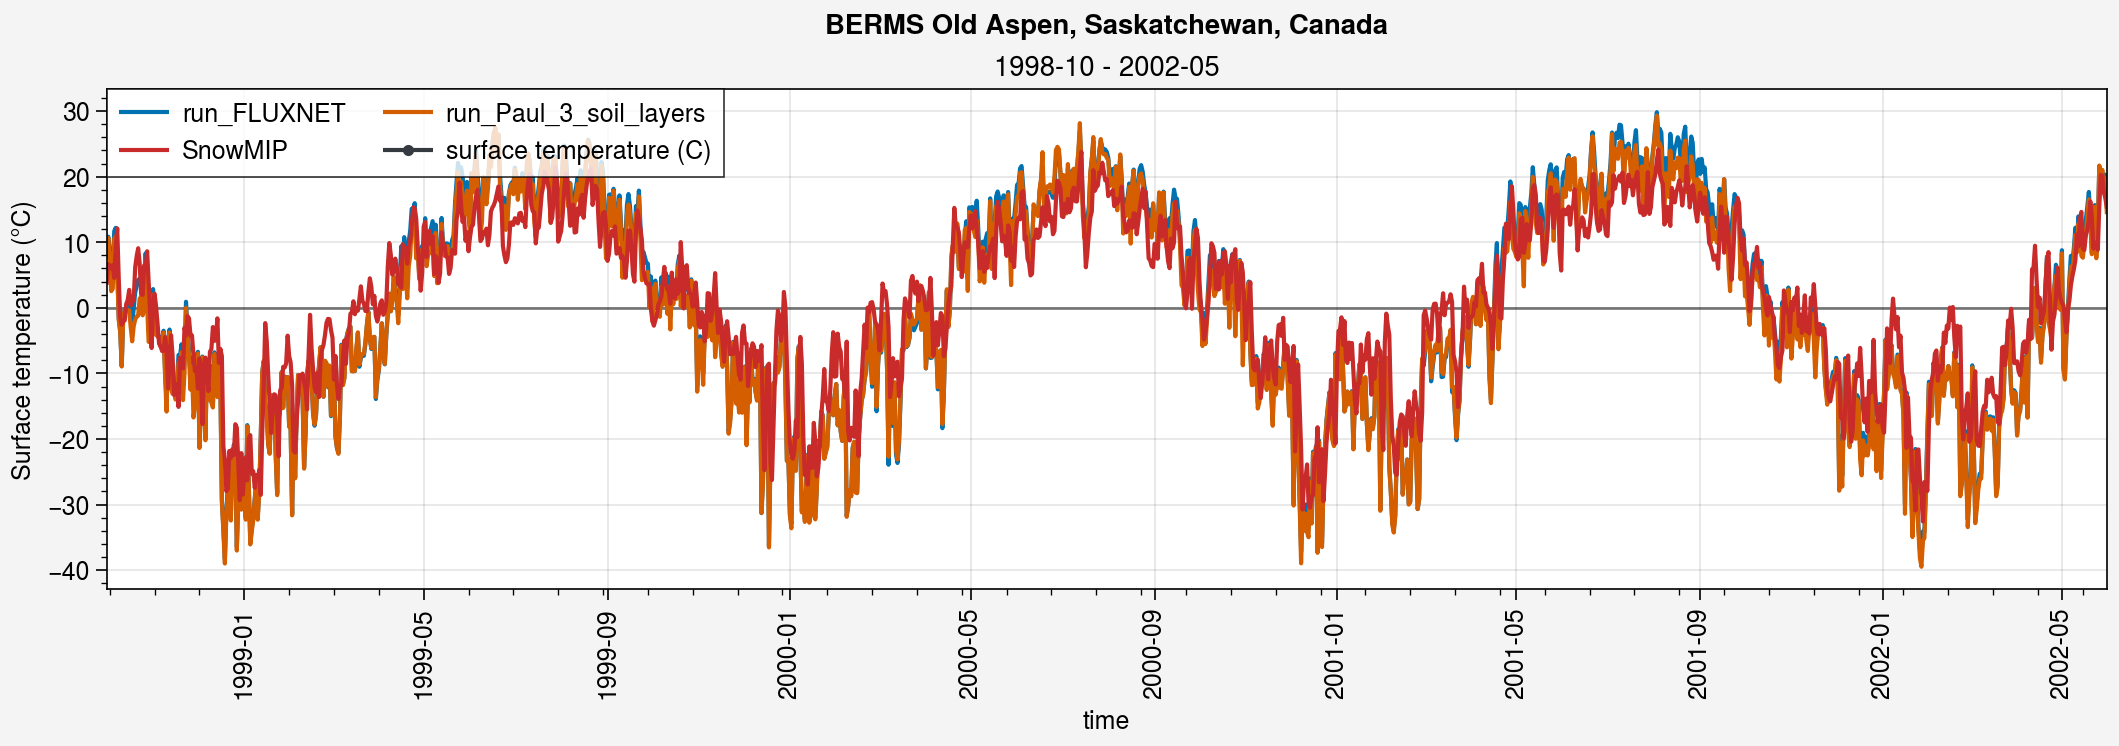

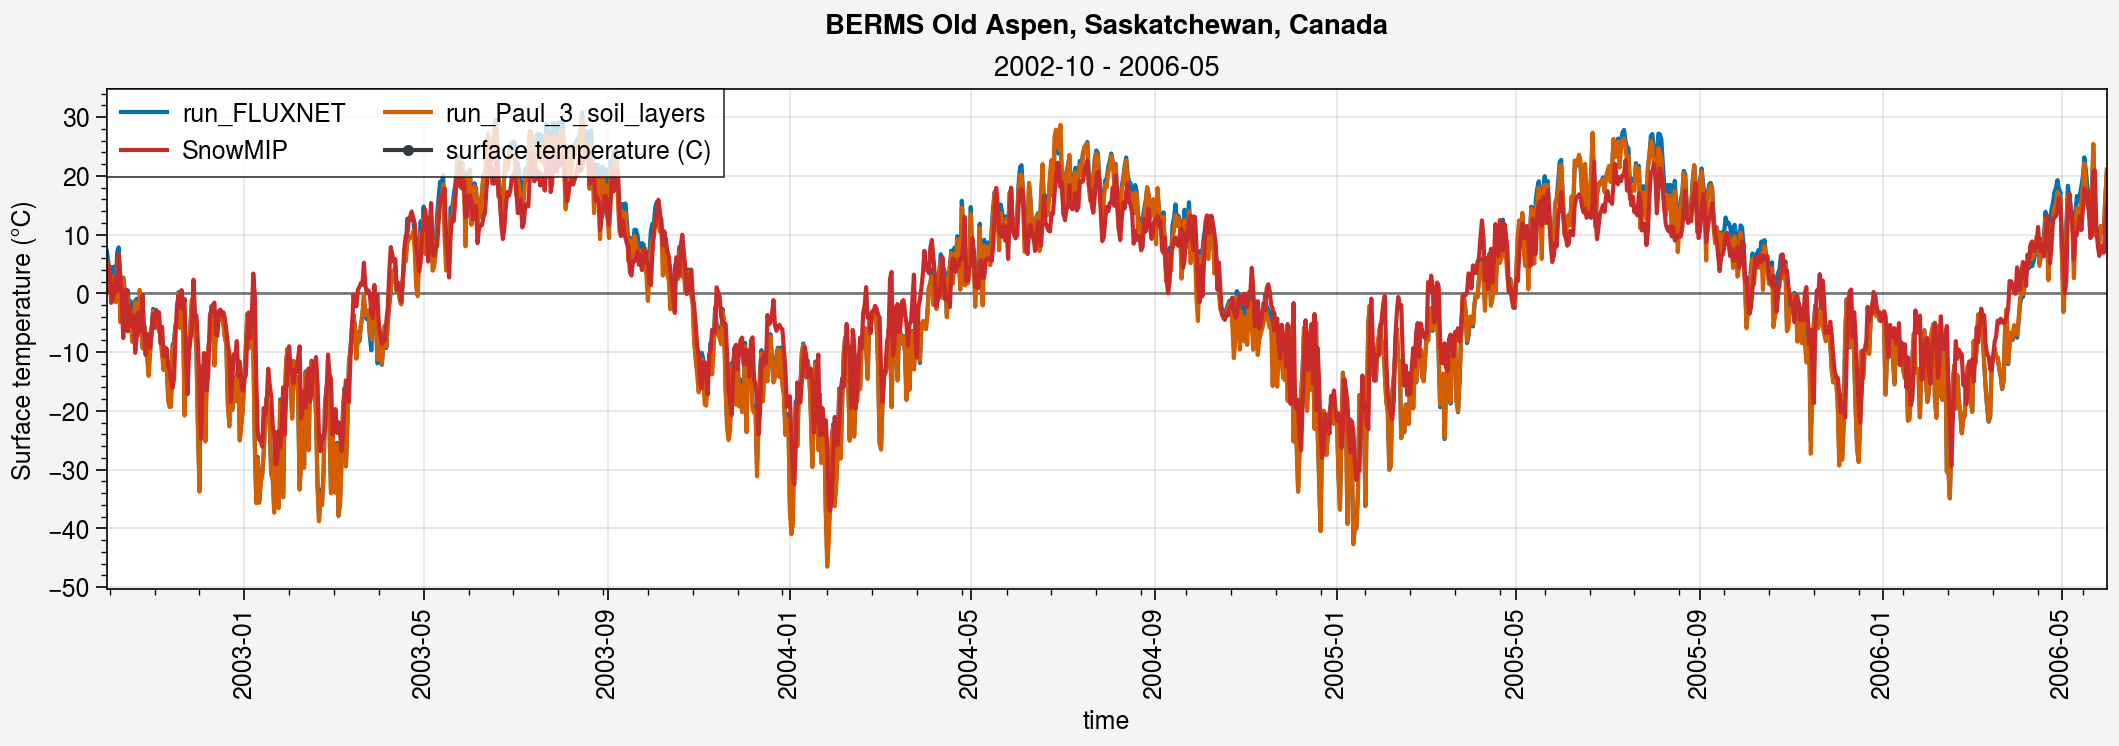

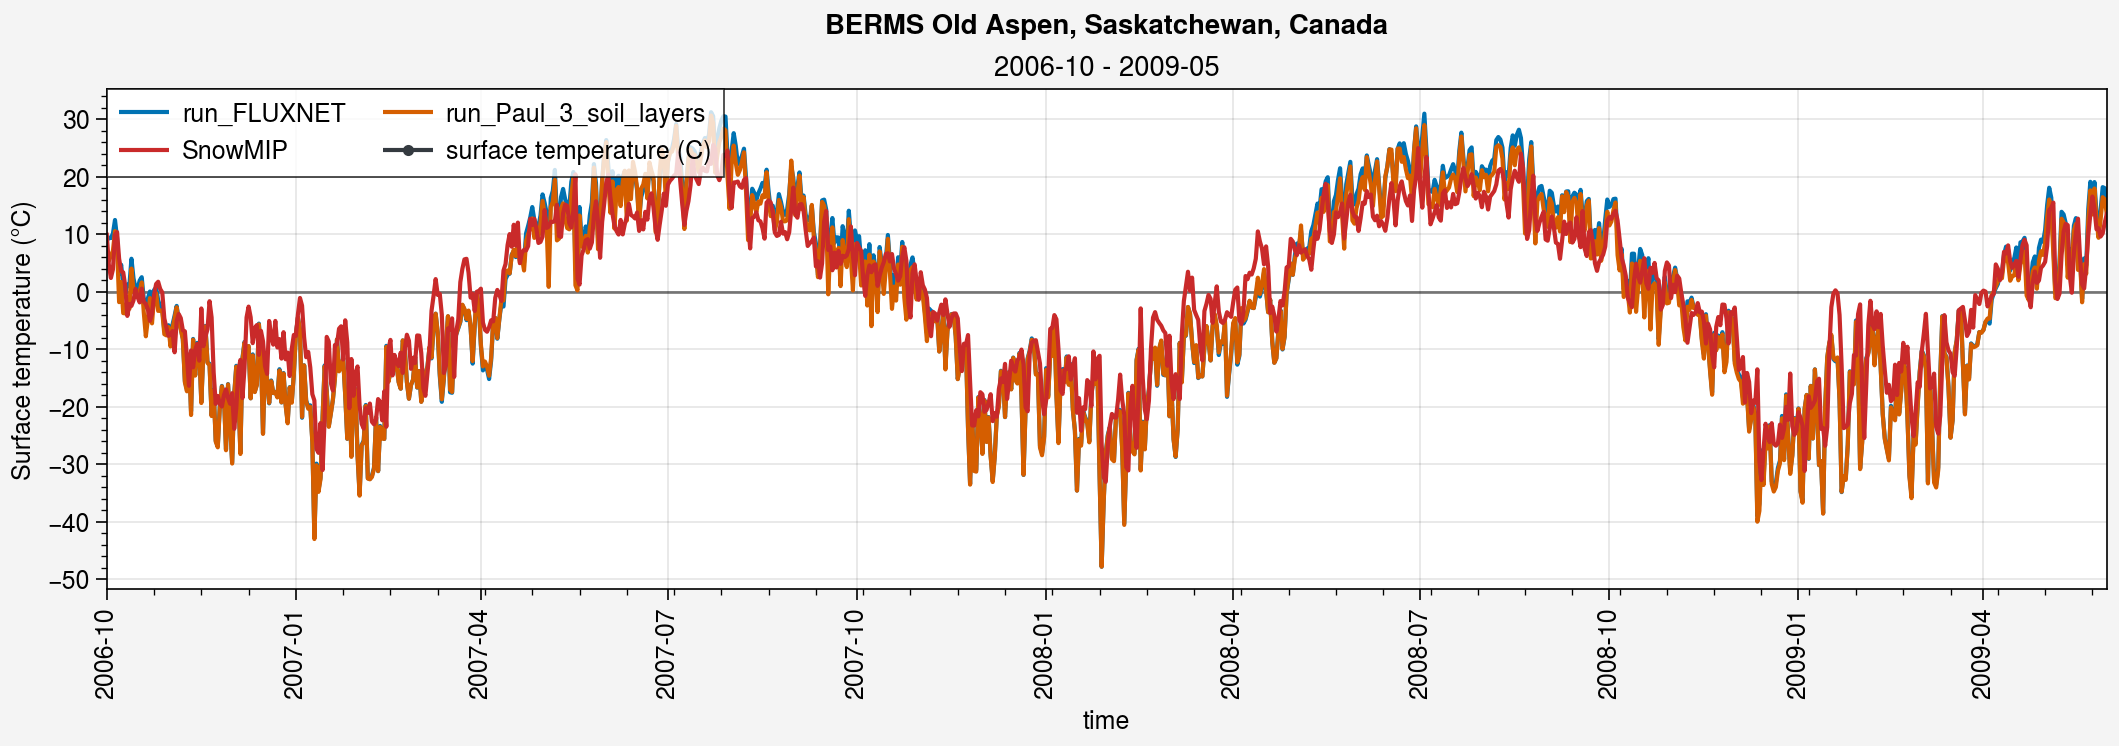

In [15]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.ts.sel(time=period)-273.15, label=label_paul, color='red9')
    
    # Obs
    axs[0].plot(ds_d_eval_menard2019.ts.sel(time=period), marker='.', color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

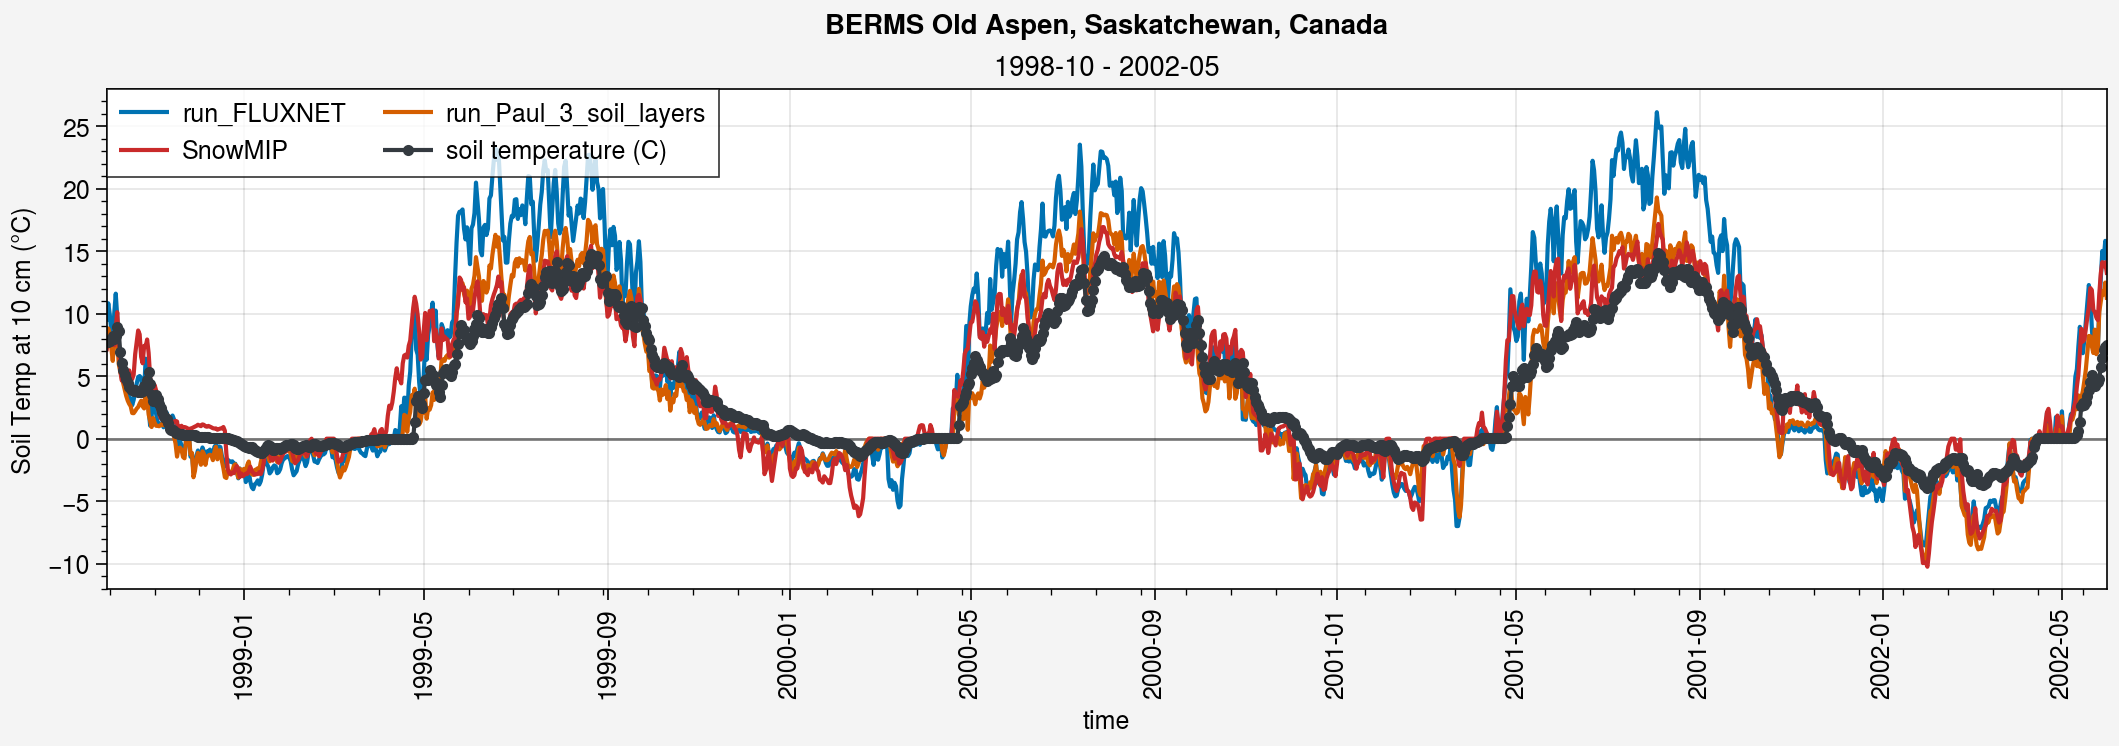

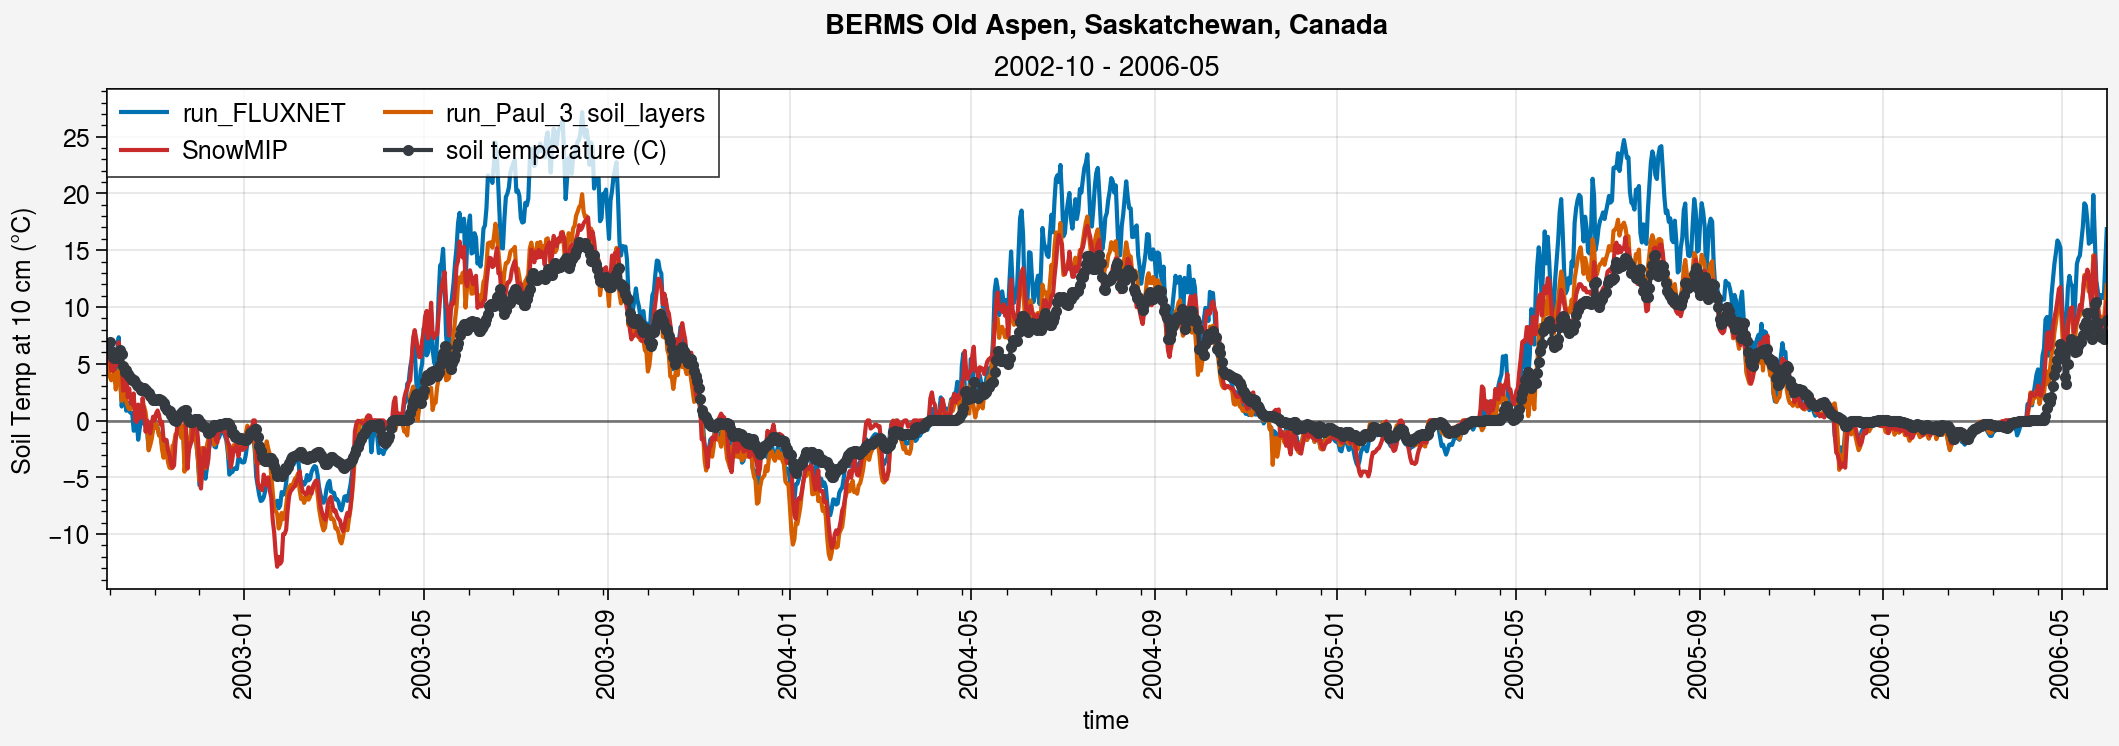

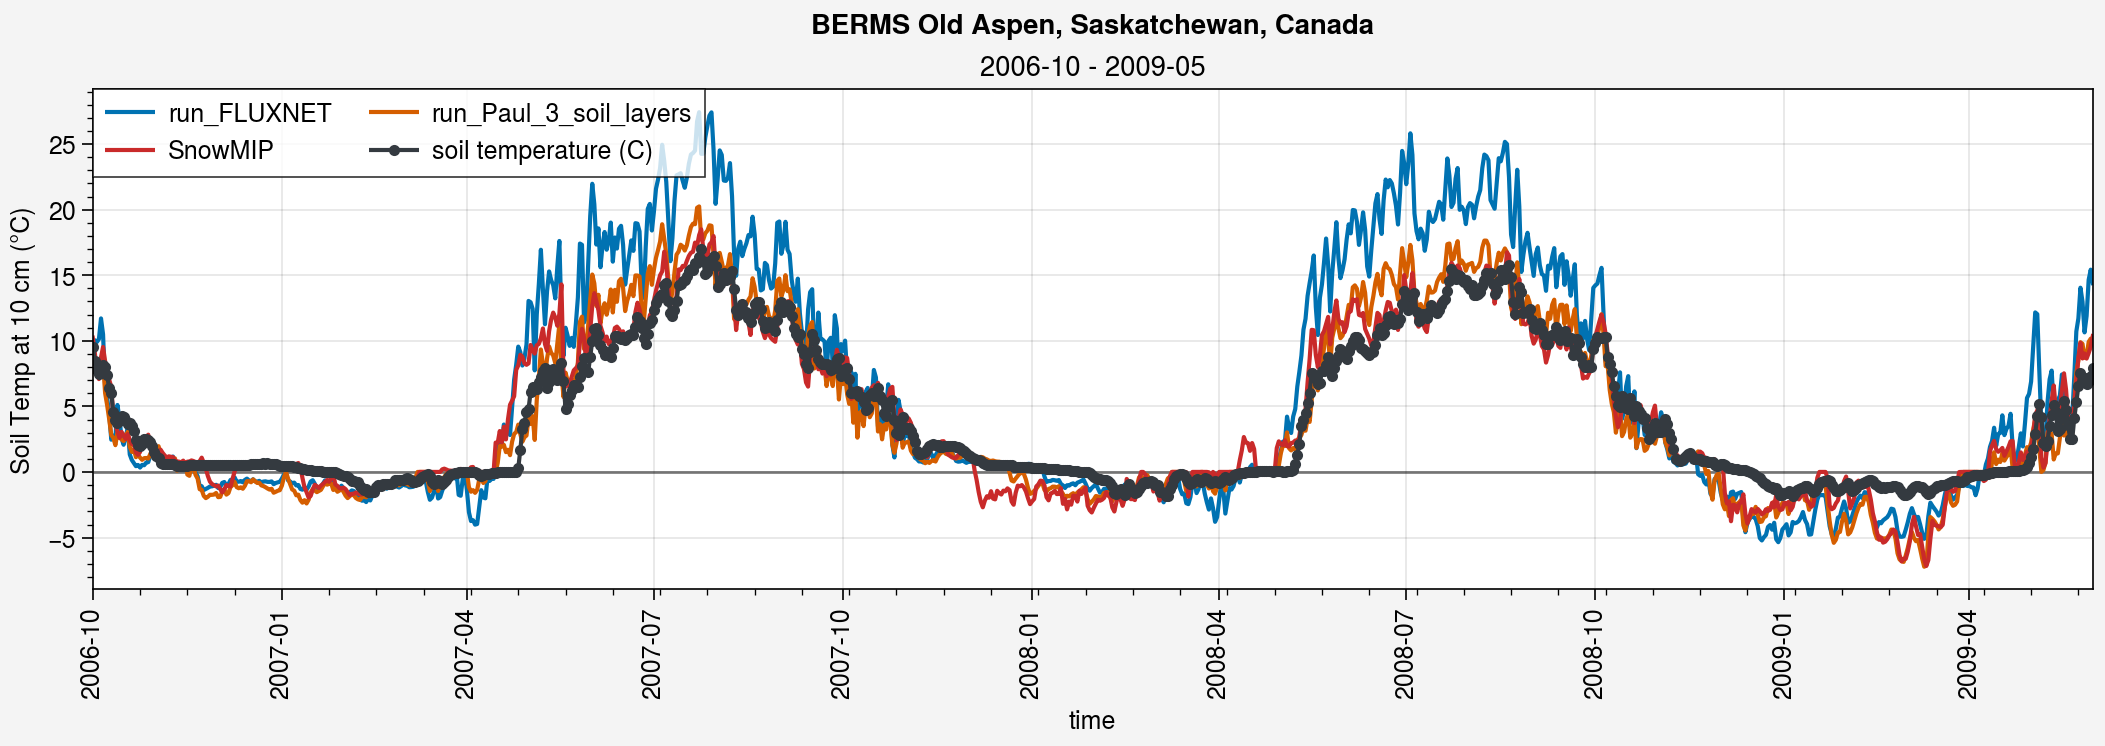

In [18]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(((0.6*ds_d.tsl.sel(time=period, layer=1)+0.4*ds_d.tsl.sel(time=period, layer=2)))-273.15, label=label)
    axs[0].plot(((0.6*ds_paul_d['tsl:1'].sel(time=period)+0.4*ds_paul_d['tsl:2'].sel(time=period)))-273.15, label=label_paul, color='red9')
    
    # Obs
    axs[0].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.1), marker='.', color=color_obs)
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_eval_menard2019.snw_can_auto.sel(time=period).values+0.1, axis=0),
    #     np.expand_dims(ds_d_eval_menard2019.snw_can_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    # axs[0].plot(ds_d_eval_menard2019.snw_can_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_eval_menard2019.snw_gap_auto.sel(time=period), color=color_obs, ls='--')
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at 10 cm (°C)')
    
    fig.suptitle(site_longname)


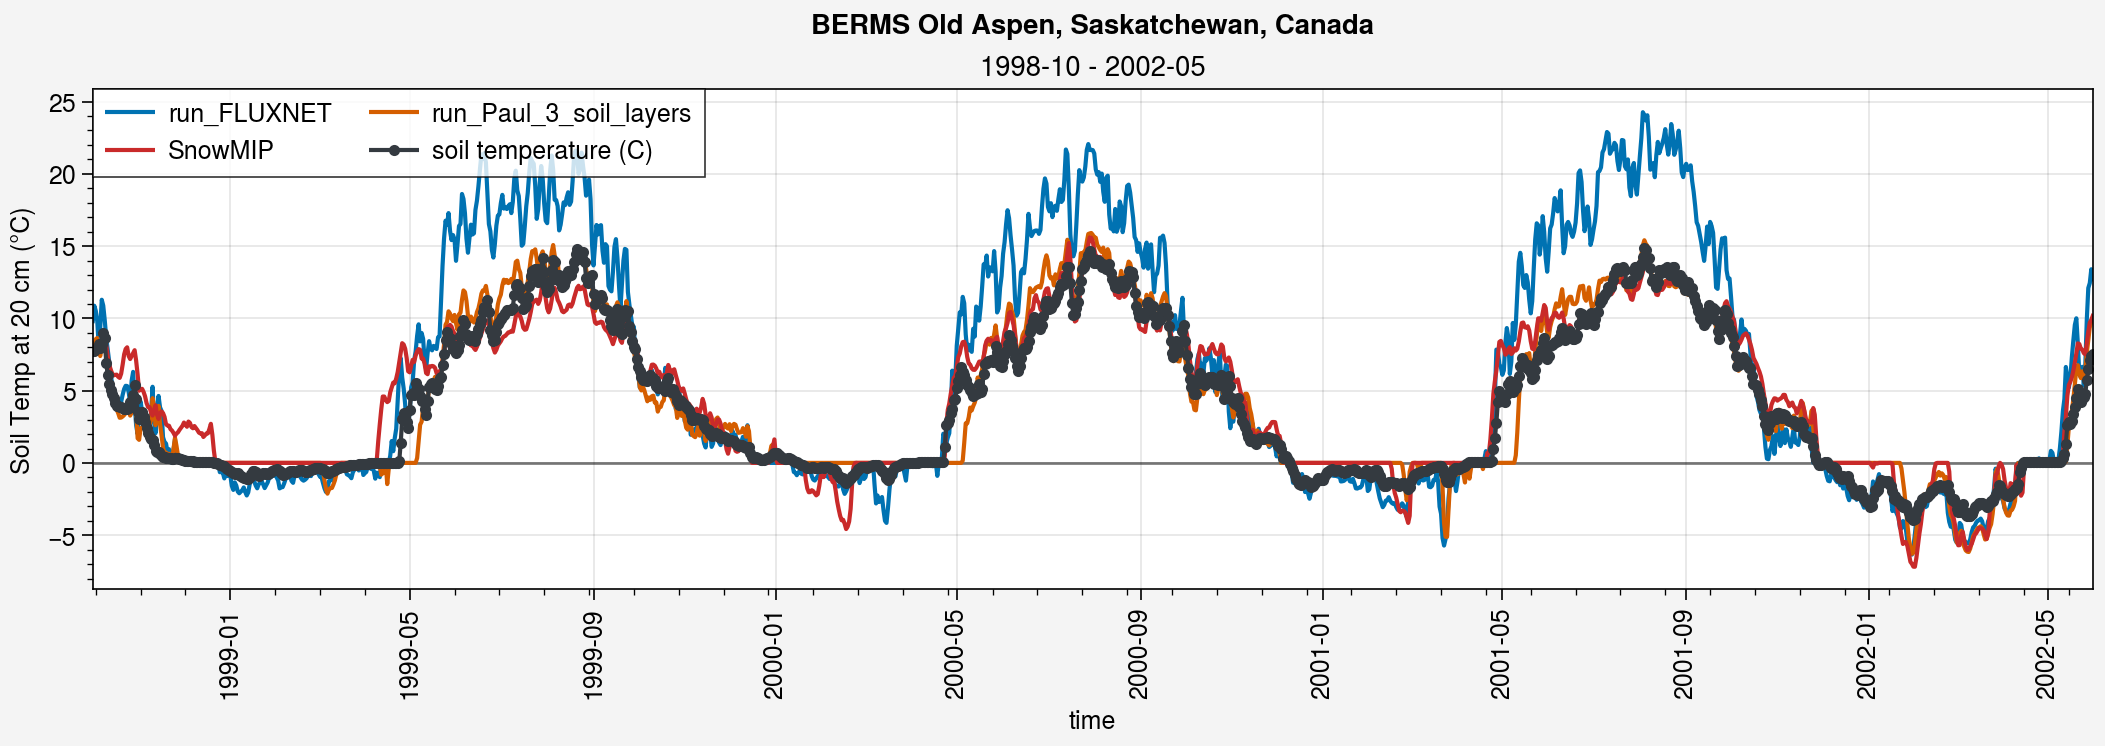

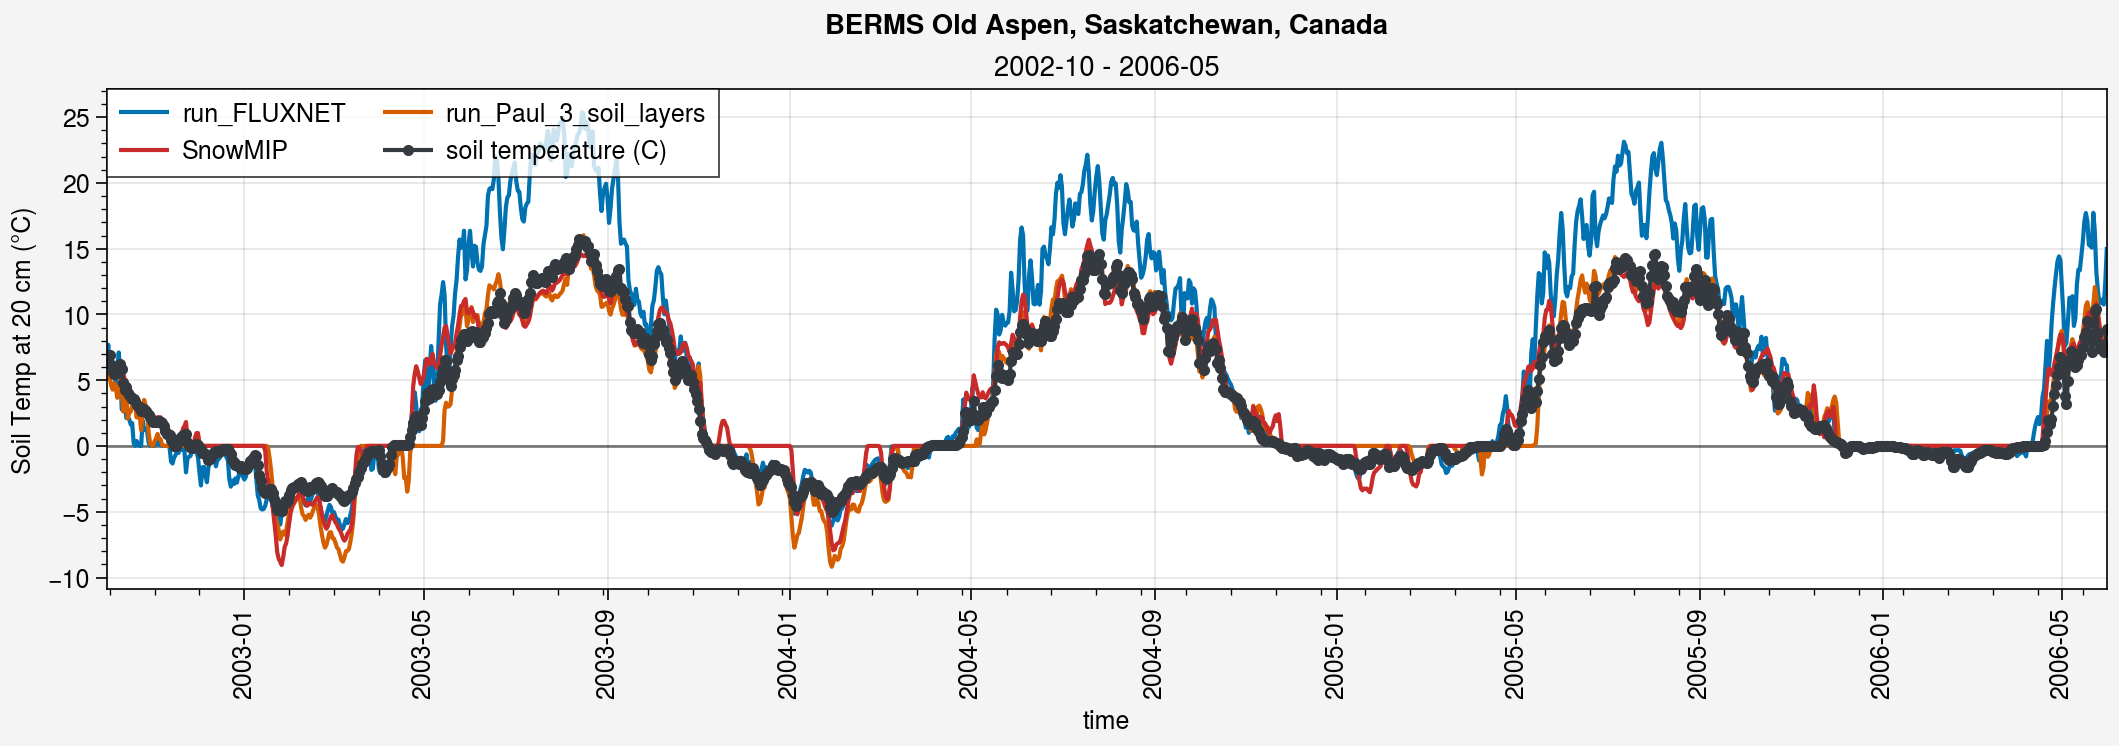

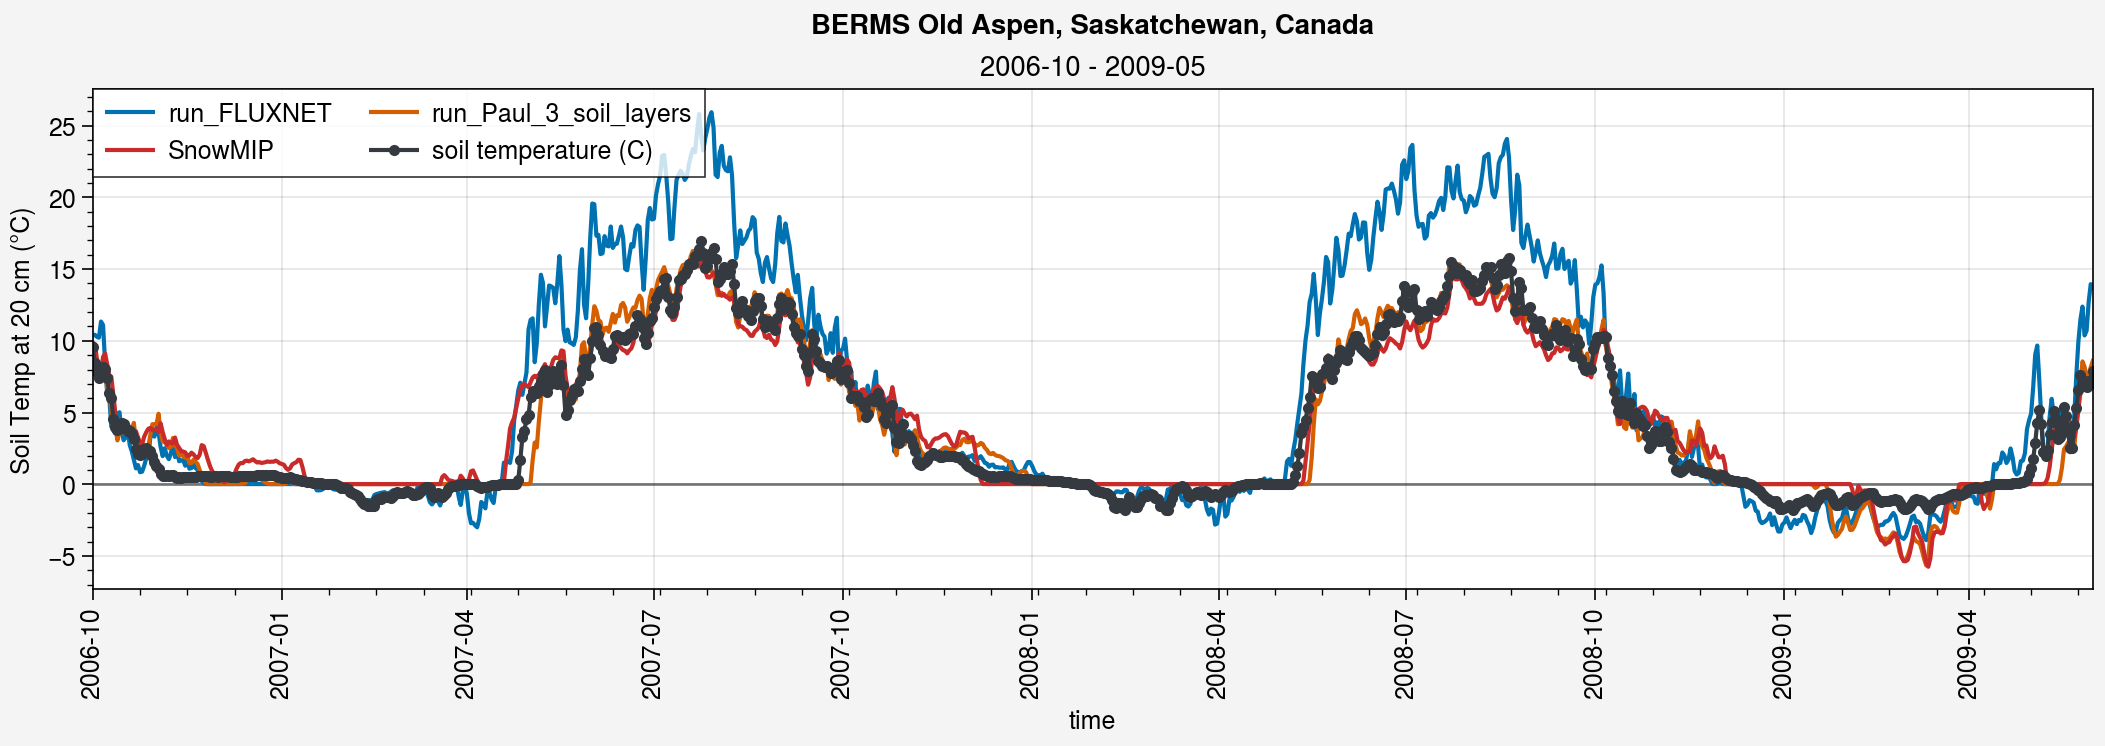

In [19]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.tsl.sel(time=period, layer=2)-273.15, label=label)
    axs[0].plot(ds_paul_d['tsl:2'].sel(time=period)-273.15, label=label_paul, color='red9')
    
    # Obs
    axs[0].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.1), marker='.', color=color_obs)
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_eval_menard2019.snw_can_auto.sel(time=period).values+0.1, axis=0),
    #     np.expand_dims(ds_d_eval_menard2019.snw_can_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    # axs[0].plot(ds_d_eval_menard2019.snw_can_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_eval_menard2019.snw_gap_auto.sel(time=period), color=color_obs, ls='--')
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at 20 cm (°C)')
    
    fig.suptitle(site_longname)
